В рамках этого небольшого демо проведем анализ торговли по скользящей средней: если MA растёт - покупаем, если падает - продаём.

Импортируем нужные нам библиотеки:

In [1]:
import pandas as pd
import requests

Будем использовать API polygon.io для получения данных. Сохраним его токен.

In [2]:
API_TOKEN = 's4Xh3zy5pAYsWrDTcfsWPhi5DX57pC26'

Для выполнения анализа нам потребуется запрос на получение данных о ценах тикеров. Вынесем переменные из запроса, чтобы можно было удобно проводить эксперименты.

In [3]:
request_name = 'ticker'
ticker = 'AAPL'
timespan = 'hour'
date_start = '2023-05-01'
date_end   = '2023-05-07'
bars_request_url = f'https://api.polygon.io/v2/aggs/{request_name}/{ticker}/range/1/{timespan}/{date_start}/{date_end}?adjusted=true&sort=asc&limit=50000&apiKey={API_TOKEN}'

Выполним запрос и распарсим данные в таблицу.

In [4]:
#в этом блоке сделаем таблицу с данными свечей
bars_data = requests.get(bars_request_url).json()
bars_data_results = bars_data['results'] #данные хранятся в листе, который является value для key 'results'

#создадим таблицу
bar_columns = ['open', 'close', 'high', 'low', 'timestamp']
bar_dataframe = pd.DataFrame(columns = bar_columns) 

#пройдемся по всем элементам листа и добавим их к таблице
for bar in bars_data_results:
    #элементы этого листа - словари
    bar_open_price  = bar['o']
    bar_close_price = bar['c']
    bar_high_price  = bar['h']
    bar_low_price   = bar['l']
    bar_timestamp   = bar['t']
    #добавляем в таблицу
    new_row = pd.Series([bar_open_price, bar_close_price, bar_high_price, bar_low_price, bar_timestamp], index = bar_columns)
    new_row = new_row.to_frame().T
    bar_dataframe = pd.concat([bar_dataframe, new_row], axis = 0, ignore_index = True)
bar_dataframe

,open,close,high,low,timestamp
0,168.40,169.00,169.80,168.26,1.682928e+12
1,169.10,168.97,169.37,168.97,1.682932e+12
2,168.90,168.85,169.09,168.77,1.682935e+12
3,168.95,168.94,169.30,168.93,1.682939e+12
4,169.15,169.49,169.49,168.88,1.682942e+12
...,...,...,...,...,...
75,174.15,173.62,174.30,173.30,1.683313e+12
76,173.56,173.49,173.69,173.00,1.683317e+12
77,173.50,173.05,173.55,173.03,1.683320e+12
78,173.06,173.27,173.27,173.05,1.683324e+12


Рассчитаем Simple Moving Average по ценам закрытия

In [5]:
bar_dataframe['SMA'] = '' #добавляем колонку для значений SMA
window = 10 #количество периодов для расчёта средней, должно быть > 0
for i in range(1, len(bar_dataframe.index)+1):
    sma = 0
    for j in range(i-min(i,window),i):
        sma = sma + float(bar_dataframe.loc[j,'close'])
    sma = sma/min(i,window)
    bar_dataframe.loc[i-1,'SMA'] = sma

bar_dataframe

,open,close,high,low,timestamp,SMA
0,168.40,169.00,169.80,168.26,1.682928e+12,169.0
1,169.10,168.97,169.37,168.97,1.682932e+12,168.985
2,168.90,168.85,169.09,168.77,1.682935e+12,168.94
3,168.95,168.94,169.30,168.93,1.682939e+12,168.94
4,169.15,169.49,169.49,168.88,1.682942e+12,169.05
...,...,...,...,...,...,...
75,174.15,173.62,174.30,173.30,1.683313e+12,172.51756
76,173.56,173.49,173.69,173.00,1.683317e+12,172.91756
77,173.50,173.05,173.55,173.03,1.683320e+12,173.21356
78,173.06,173.27,173.27,173.05,1.683324e+12,173.53956


Теперь будем принимать решение о продаже или покупке следующим образом:
Если позиция не открыта: заходим в лонг/шорт если SMA выросла/упала на percentage_treshold процентов, относительно предыдущего тика
Если позиция открыта: лонг, держим, пока SMA растёт, шорт - пока падает.

<Axes: xlabel='timestamp'>

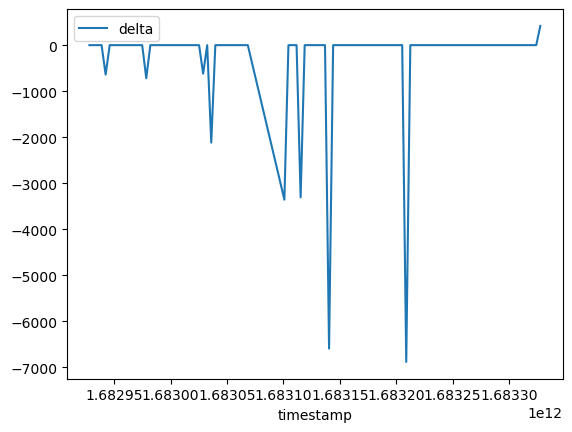

In [6]:
stock_amount = 1000 #количество акций для лонга/шорта
percentage_treshold = 0.01;
bar_dataframe['position'] = '0' #колонка, в которой будем хранить текущую позицию
bar_dataframe['sma_change, %'] = '0' #колонка, в которой будем хранить изменения SMA для наглядности
bar_dataframe['action'] = '0' #колонка, в которой будем хранить принятое решение
bar_dataframe['delta'] = 0 #колонка, в которой будем хранить изменение по счёту
delta = 0 #переменная для хранения измненения по счету

for i in range(1, len(bar_dataframe.index)):
    sma_current      = float(bar_dataframe.loc[i,'SMA']) #текущее значение SMA
    sma_previous     = float(bar_dataframe.loc[i-1,'SMA']) #предыдущее значение SMA
    position_current = float(bar_dataframe.loc[i-1,'position']) #текущая позиция
    position_current_for_delta = float(bar_dataframe.loc[i-1,'position']) #текущая позиция, которую мы сохраним до конца расчётов
    sma_change       = (sma_current-sma_previous)*100/sma_previous #расчёт изменения SMA в процентах
    bar_dataframe.loc[i,'sma_change, %'] = sma_change
    price_current    = bar_dataframe.loc[i,'close']
    #принимаем решение о сделке и осуществляем её
    if position_current == 0: 
        if sma_change >= percentage_treshold:
            position_current += stock_amount
            bar_dataframe.loc[i,'action']    = 'buy'
        if sma_change <= (-1)*percentage_treshold:
            position_current -= stock_amount
            bar_dataframe.loc[i,'action']    = 'sell'
    if (position_current > 0 and sma_change < 0) or (position_current < 0 and sma_change > 0):
        position_current = 0
        bar_dataframe.loc[i,'action'] = 'close'
    bar_dataframe.loc[i,'position'] = position_current
    action_current   = bar_dataframe.loc[i,'action']
    #сохраняем цену сделки на будущее, если мы открыли позицию
    if action_current == 'sell' or action_current == 'buy': 
        price_action = price_current 
    #считаем прибыль, если закрыли позицию
    if action_current == 'close':
        if (position_current_for_delta > 0):
            delta += (price_current - price_action)*stock_amount
        if (position_current_for_delta < 0):
            delta += (price_current - price_action)*stock_amount*(-1)
        bar_dataframe.loc[i,'delta'] = delta 

bar_dataframe.plot(x = 'timestamp', y = 'delta') #мне пора идти, поэтому график только в таком виде, точки с delta = 0 игнорируем :)
